# Exp011: Corpus Rule Detection
For a good external validation, each rule is searched for in the corpus and marked if there is at least 80% precision among the hits. If there are less than 5 hits in the first ten examples, the rule is skipped, otherwise 10 more appear.

In [1]:
import pandas as pd
import numpy as np
from torch import save, load, no_grad
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import sys
sys.path.append('../source')
import models
import data
import helpers
import api
#import importlib
#importlib.reload(models)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/home/dglandorf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load datasets

In [2]:
# egp instances
egp_examples = pd.read_json("../data/egp_gpt35.json")
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(100000)
encoded_inputs = models.bert_tokenizer(sentences, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
# output dataset
output_path = '../data/coded_corpus_hits_05.json'
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(output_path) else pd.read_json(output_path)

100%|███████████████████████████████████████████████| 4/4 [00:38<00:00,  9.57s/it]


for each rule:
- train classifier with existing dataset
- search corpus
- output rule to user
- ask for user input until the precision is clear enough

In [58]:
def get_dataset(positives, negatives, others, tokenizer, max_len, others_ratio = 3):
    unique_positive = list(set(positives)) # remove duplicates
    unique_negative = list(set(negatives).difference(set(positives))) # remove duplicates and positives
    num_rands = int(others_ratio * len(unique_negative))
    random.shuffle(others)
    sentences = unique_positive + unique_negative + others[:num_rands]
    labels = [1] * len(unique_positive) + [0] * len(unique_negative) + [0] * len(others[:num_rands])
    print(sum(labels) / len(labels))
    return data.SentenceDataset(sentences, labels, tokenizer, max_len)
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder), num_epochs=3):
    dataset = get_dataset(positive, negative, others, models.bert_tokenizer, 64) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, accuracy = models.train(classifier, train_dataloader, val_dataloader, num_epochs)
    return classifier, accuracy
def get_others(egp, nr):
    return [example for sublist in egp.loc[egp['#'] != nr, 'augmented_examples'].to_list() for example in sublist]

In [4]:
def criterion(coded_instances, min_precision=0.8, num_rules=1):
    correct_per_rule = coded_instances.groupby('#')['correct'].mean()
    return len(correct_per_rule[correct_per_rule > min_precision]) > num_rules

In [20]:
accuracies = {}

In [61]:
while not criterion(coded_instances, num_rules=19):
    rule = egp_examples.sample(1).iloc[0] # sample random rule
    if rule['#'] in coded_instances['#']: continue
    print(f"{rule['type']}: {rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])

    classifier, accuracy = get_trained_classifer(rule['augmented_examples'], rule['augmented_negative_examples'], get_others(egp_examples, rule['#']), num_epochs=5)
    accuracies[rule['#']] = accuracy
    scores, tokens = models.score_corpus(classifier, dataloader, max_positive=250, max_batches=250)
    results = iter([(score, token, sample) for score, token, sample in zip(scores, tokens, sentences[:len(scores)]) if score > 0.5])
    while len(coded_instances[coded_instances['#'] == rule['#']]) < 20:
        score, token, sample = next(results)
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [rule['#']],
             'sentence': [sample],
             'correct': [True if user_response == '2' else False],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
        coded_instances.to_json(output_path)

FORM: Can use 'few', 'many', 'most', 'others' to refer to people in formal written contexts, often reports or surveys.  (PRONOUNS: quantity)
Few people stop to think about what they are really doing, and few are motivated to work at all. 

Few denied that it was one of the most thrilling and fascinating activities we tried the whole week. 

Many express their satisfaction and claim to have acquired a great number of new skills. 

Many say that extreme sports attract only those who are addicted to adrenaline or those who have nothing to lose. 

Some of the students have a few comments. Most were concerned with the planning of the timetable and I hope there may be some changes this year.
500
['Most top executives have reasons to doubt the success of the upcoming product launch.', 'Most respondents reported feeling overwhelmed by the workload, while some others indicated a feeling of accomplishment and satisfaction.', 'Most scientists are close-minded to collaborating with colleagues from

100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.13it/s]


Training loss: 0.46048311848898194
Accuracy: 0.8344594594594594


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.41it/s]


Training loss: 0.338799919228296
Accuracy: 0.875


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.43it/s]


Training loss: 0.31338065137734283
Accuracy: 0.875


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.43it/s]


Training loss: 0.2877830554907386
Accuracy: 0.8817567567567568


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.41it/s]


Training loss: 0.28505930022613424
Accuracy: 0.8851351351351351


  5%|██                                        | 250/5247 [00:40<13:24,  6.21it/s]


However, there are so few places left that have not been affected by global warming. 1
On top fo all of that, she didn't seem to have any sense about people's personal space. 1
Once we were asked to watch a video on how to operate the punches, all of us seemed to fall into sleep by the end of the video. 2
All the prices on the list are subject to our final confirmation. 1
It takes most of our weekends to listen to these boring lectures, so I can not bear it anymore. 1
Let's discuss the clauses to see if we agree on all of them. 1
All of them have first-class quality and performance. 1
But only a few of them are influential world-wide. 1
But many of them are good. 1
Many of us still have a mountain of work to do before the day's end. 2
Next you fill in all of your hours for each day and total them. 1
I've got all of your information here on the screen in front of me. 1
well, most of them only need a cap and gown for that particular convocation service, but some of the education majors h

FORM: Can use the negative forms with a range of pronouns and an increasing range of verbs.  (PAST: present perfect simple)
He hasn't spoken to anyone from that time till now. 

She is a quiet person so she has not made a lot of friends. 

We haven't decided where to go yet, but probably it will be to somewhere like Australia or New Zealand.
515
['I have received emails today.', 'She has heard from her professor about the exam results already.', "You finished your homework, didn't you?", 'We had visitors over the weekend.', 'He had realized how much time had passed.', 'Have you visited the museum in your hometown?', 'She has heard from him since they had an argument.', 'She understood the instructions clearly and completed her task successfully.', 'She prepared for the job interview adequately, and she impressed the interviewers.', 'You mentioned your travel plans to me before today.']
750
0.33993399339933994


100%|█████████████████████████████████████████████| 38/38 [00:03<00:00, 11.61it/s]


Training loss: 0.4028129044332002
Accuracy: 0.9306930693069307


100%|█████████████████████████████████████████████| 38/38 [00:03<00:00, 11.93it/s]


Training loss: 0.12508084066212177
Accuracy: 0.9735973597359736


100%|█████████████████████████████████████████████| 38/38 [00:03<00:00, 11.92it/s]


Training loss: 0.08758384959870263
Accuracy: 0.976897689768977


100%|█████████████████████████████████████████████| 38/38 [00:03<00:00, 11.87it/s]


Training loss: 0.07485187480128125
Accuracy: 0.9834983498349835


100%|█████████████████████████████████████████████| 38/38 [00:03<00:00, 11.89it/s]


Training loss: 0.06553153799062497
Accuracy: 0.9834983498349835


  5%|██                                        | 250/5247 [00:40<13:21,  6.24it/s]


You didn't come to reconfirm recently.You should have come to pick up your ticket three days ago since it's an international flight, any reservation without reconfirmation within 72 hours will be cancelled. 1
I've been here for 3 years, and I haven't had a raise in all that time. 1
I didn't realize it. 11
He's not answering. 1
I called the first three people on the list, but they didn't pick up. 1
I got it a while ago, but I haven't worn it much. 1
However, there are so few places left that have not been affected by global warming. 2
I haven't even told you what it is yet! 2
They didn't have much training. 1
There don't seem to be any in the soft drink section. 1
I've never seen this kind of office printer before. 1
Haven't seen you for a long time 1
You didn't show up to my performance last night! 1
I haven't decided yet. 1
And I don't see any loose electric wiring that could cause fires. 1
I can't remember, but I've got the receipt somewhere. 1
We don't know, but he's going to the do

FORM: Can use 'few', 'many', 'most', 'others' to refer to people in formal written contexts, often reports or surveys.  (PRONOUNS: quantity)
Few people stop to think about what they are really doing, and few are motivated to work at all. 

Few denied that it was one of the most thrilling and fascinating activities we tried the whole week. 

Many express their satisfaction and claim to have acquired a great number of new skills. 

Many say that extreme sports attract only those who are addicted to adrenaline or those who have nothing to lose. 

Some of the students have a few comments. Most were concerned with the planning of the timetable and I hope there may be some changes this year.
500
['Most top executives have reasons to doubt the success of the upcoming product launch.', 'Most respondents reported feeling overwhelmed by the workload, while some others indicated a feeling of accomplishment and satisfaction.', 'Most scientists are close-minded to collaborating with colleagues from

100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.38it/s]


Training loss: 0.35661317246991237
Accuracy: 0.8547297297297297


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.56it/s]


Training loss: 0.2570177014615085
Accuracy: 0.8682432432432432


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.55it/s]


Training loss: 0.25049535829473185
Accuracy: 0.8682432432432432


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.52it/s]


Training loss: 0.24343118695793925
Accuracy: 0.8682432432432432


100%|█████████████████████████████████████████████| 37/37 [00:03<00:00, 11.51it/s]


Training loss: 0.23888441436999552
Accuracy: 0.8648648648648649


  1%|▌                                          | 69/5247 [00:11<13:55,  6.20it/s]


KeyboardInterrupt: 

# Analyse coded instances

In [62]:
correct_per_rule = coded_instances.groupby('#')['correct'].mean()

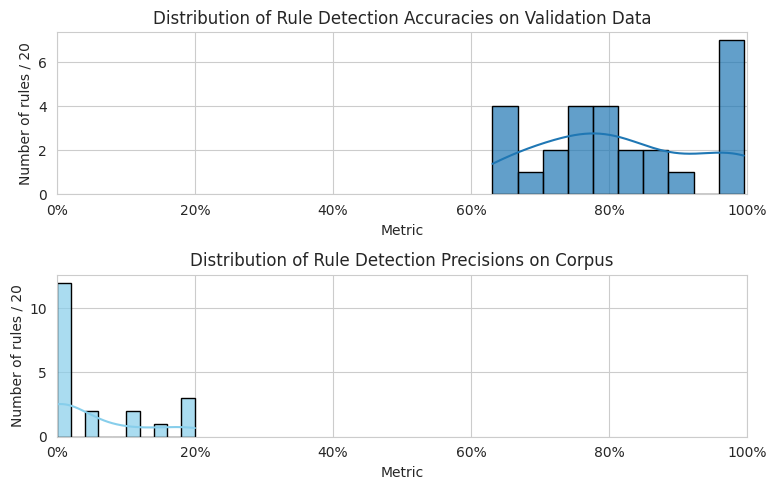

In [64]:
def plot_histogram(ax, data):
    sns.histplot(ax=ax, data=data, bins=10, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
    ax.set_ylabel(f"Number of rules / {len(correct_per_rule)}")
    ax.set_xlabel("Metric")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.set_xlim(0, 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
plot_histogram(axs[0], accuracies.values())
axs[0].set_title("Distribution of Rule Detection Accuracies on Validation Data")
plot_histogram(axs[1], list(correct_per_rule))
axs[1].set_title("Distribution of Rule Detection Precisions on Corpus")
plt.tight_layout()
plt.show()